# ***Assignment 3 for Data Analysis 3***

Conducted by Ian Brandenburg and Zsófia Rebeka Katona

[GitHub Repo](https://github.com/Iandrewburg/DA3_Brandenburg/tree/main/Assignment_3)



Developing a predictive model to identify which small or medium-sized firms in the "Manufacture of computer, electronic, and optical products" industry might fail in 2015, based on their activity in 2014.

[**Data source**](https://osf.io/b2ft9/?view_only=):
Detailed company data from a middle-sized country in the European Union
All registered companies in 2005-2016 in three selected industries 
  (auto manufacturing, equipment manufacturing, hotels and restaurants)
This rich database was constructed for from multiple publicly available sources 
by Bisnode, a business data and anlytics company www.bisnode.com
for educational purposes

Dependent Variable - Dummy Variable for if the company defaulted or not

In [656]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from plotnine import *
from mizani.formatters import percent_format
import ast
from patsy import dmatrices
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, auc, brier_score_loss, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay, partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.calibration import calibration_curve
import time

In [653]:
# Helper Functions

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_calibration_plot(data, file_name, prob_var, actual_var, y_lab, n_bins=10, breaks=None):
    prob_true, prob_pred = calibration_curve(data[actual_var], data[prob_var], n_bins=n_bins, strategy='uniform')
    
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(prob_pred, prob_true, "s-", label="Model")
    plt.xlabel("Predicted probability")
    plt.ylabel(y_lab)
    plt.title("Calibration Plot")
    plt.legend()
    plt.grid(True)
    
    plt.savefig(file_name + ".png", dpi=300)
    plt.show()
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

# ***1. Data Processing***

## 1.1 Import Data Directly from GitHub

In [530]:
data = pd.read_csv('https://github.com/Iandrewburg/DA3_Brandenburg/raw/main/Assignment_3/cs_bisnode_panel.csv')
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [531]:
data

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1.001034e+06,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1.001034e+06,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1.001034e+06,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1.001034e+06,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1.001034e+06,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287824,4.641209e+11,2011-01-01,2011-12-31,NaN,0.000000,1807.407349,3.703704,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287825,4.641209e+11,2012-01-01,2012-12-31,NaN,0.000000,1518.518555,96.296295,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287826,4.641209e+11,2013-01-01,2013-12-31,NaN,0.000000,988.888916,77.777779,0.0,0.0,0.0,...,NaN,NaN,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287827,4.641209e+11,2014-01-01,2014-12-31,NaN,0.000000,644.444458,233.333328,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN


In [532]:
# Checking out the column names
data.columns

Index(['comp_id', 'begin', 'end', 'COGS', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'finished_prod',
       'fixed_assets', 'inc_bef_tax', 'intang_assets', 'inventories',
       'liq_assets', 'material_exp', 'net_dom_sales', 'net_exp_sales',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'wages', 'D', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'year', 'founded_year',
       'exit_year', 'ceo_count', 'foreign', 'female', 'birth_year',
       'inoffice_days', 'gender', 'origin', 'nace_main', 'ind2', 'ind',
       'urban_m', 'region_m', 'founded_date', 'exit_date', 'labor_avg'],
      dtype='object')

In [533]:
# Checking out the info of the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

## 1.2 Label Engineering

In [534]:
# Set the index to the columns of interest
data = data.set_index(["year", "comp_id"])

# Perform the unstack operation, which will automatically introduce NaNs for missing combinations
data = data.unstack().stack(dropna=False)

# Reset the index to make 'year' and 'comp_id' regular columns again
data = data.reset_index()

# Note: The unstack() and stack(dropna=False) operations introduce NaNs for missing entries automatically.


In [535]:
# Generate status_alive; if sales are larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)


# It defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)


In [536]:
data['status_alive'].value_counts()

status_alive
0    318453
1    238491
Name: count, dtype: int64

In [537]:
data['default'].value_counts()

default
0    507577
1     49367
Name: count, dtype: int64

In [538]:
data['default'].describe()

count    556944.000000
mean          0.088639
std           0.284222
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

This concludes that 311,016 firms defaulted and 245,928 firms stayed alive, and 2 years later, 274,393 will stay alive and 13,436 firms will default.

In [539]:
data['sales'].describe()

count    2.803920e+05
mean     5.042513e+05
std      3.861890e+06
min     -1.472559e+07
25%      5.295370e+03
50%      3.280741e+04
75%      1.210056e+05
max      1.110294e+08
Name: sales, dtype: float64

In [540]:
# Replacimg negative sales values with 1. This operation is done outside of 
# ...the `assign` method because it's a direct modification of the dataframe.
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)

# Adding new columns to the dataframe through the `assign` method.
data = data.assign(
    # Create a new column 'ln_sales'. If sales are greater than 0, calculate the natural logarithm of sales.
    # If sales are NaN, keep them as NaN. Otherwise, set to 0. This ensures that negative sales, 
    # ...if any existed before the first operation, now converted to 1, won't result in a math error.
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
    # Convert sales to millions by dividing by 1,000,000 for easier readability and analysis.
    sales_mil=data["sales"] / 1000000,
    # Similar to 'ln_sales', but this time applying the logarithm to the sales converted to millions. 
    # ...Handles NaN and non-positive values similarly.
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [541]:
# Calculating the year-over-year change in the logarithm of sales (in millions) by subtracting 
# ...the previous year's value from the current year's value for each company.
data['d1_sales_mil_log']=data['sales_mil_log']-data.groupby('comp_id')['sales_mil_log'].shift(1)


In [542]:
# Calculating the age of each company by subtracting the founding year from the current year. 
# ...If the result is negative (which might happen due to data errors), set the age to 0.
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)

# Identifying new companies or those without a full year of balance sheet data. 
# ...Mark them with a 1, others with a 0. If 'age' is NaN, keep it as NaN.
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)

# For new companies, set the year-over-year change in log sales to 0. 
# ...This adjustment is for handling new entries or missing data appropriately.
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)

# If the year-over-year change in log sales is NaN, consider the company 
# ...as new and update the 'new' column accordingly.
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])

# Replacing NaN values in 'd1_sales_mil_log' with 0, ensuring the dataset 
# ...does not have missing values in this calculation.
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [543]:
data['new'].describe()

count    556944.000000
mean          0.680936
std           0.466114
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

This concludes that there are 556,944 new firms.

In [544]:
data.isna().sum()

year                         0
comp_id                      0
begin                   269115
end                     269115
COGS                    538687
amort                   277155
curr_assets             269246
curr_liab               269246
extra_exp               287644
extra_inc               287644
extra_profit_loss       286318
finished_prod           539459
fixed_assets            269246
inc_bef_tax             276552
intang_assets           269255
inventories             269246
liq_assets              269246
material_exp            277155
net_dom_sales           538687
net_exp_sales           538687
personnel_exp           277155
profit_loss_year        278999
sales                   276552
share_eq                269246
subscribed_cap          269246
tang_assets             270585
wages                   538961
D                       556944
balsheet_flag           269115
balsheet_length         269115
balsheet_notfullyear    269115
founded_year            325572
exit_yea

## 1.3 Feature Engineering

In [545]:
# Categorizing the industry codes into broader groups
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [546]:
# Checking out the industry codes using comp_id as a reference
data.groupby('ind2_cat').count()['comp_id']

ind2_cat
20.0       675
26.0     14877
27.0      9116
28.0     26098
29.0      4379
30.0      2499
32.0      1820
33.0     21839
35.0         6
40.0      2766
55.0     33756
56.0    165521
60.0      3439
99.0    270153
Name: comp_id, dtype: int64

In [547]:
# Adding more variables as firm characteristics
data["age2"] = data["age"] ** 2

# Grouping values for foreign_management as dummies 
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)

# Creating new columns for the categorical gender and and region variables
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

### Looking at financial variables and creating additional ones

In [548]:
# Looking at financial variables and creating new financial ratios

# As assets cannot be negative: transforming the negative asset values to 0 and flagging them
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    287466
1.0       223
Name: comp_id, dtype: int64

In [549]:
# Tranforming the negative asset variables to 0
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [550]:
# Generating the total assets balance sheet variable by adding up the intangible, current and fixed assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    2.876890e+05
mean     5.980575e+05
std      2.623770e+07
min      0.000000e+00
25%      4.792593e+03
50%      2.024815e+04
75%      8.810741e+04
max      1.032471e+10
Name: total_assets_bs, dtype: float64

In [551]:
# Collecting the profit and loss names
pl_names = ['extra_exp',
            'extra_inc',
            'extra_profit_loss',
            'inc_bef_tax',
            'inventories',
            'material_exp',
            'profit_loss_year',
            'personnel_exp']
# Collecting the balance sheet names
bs_names = ['intang_assets',
            'curr_liab',
            'fixed_assets',
            'liq_assets',
            'curr_assets',
            'share_eq',
            'subscribed_cap',
            'tang_assets' ]

In [552]:
# Scaling the the pl_names elements by dividing them with sales and creating a new column for them
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [553]:
# Creating new columns for bs_names by dividing each specified column by total_assets_bs
for col in bs_names:
    # Assuming bs_names does not already include "_bs"
    new_col_name = f"{col}_bs"
    # Replacing Infinite and NaN values with 0 in the new column
    data[new_col_name] = data[col].div(data["total_assets_bs"]).replace((np.inf, -np.inf, np.nan), 0)
    
    # Set values to NaN where total_assets_bs is NaN
    data[new_col_name] = np.where(data["total_assets_bs"].isna(), np.nan, data[new_col_name])


In [554]:
# Creating new columns for bs_names by dividing each specified column by total_assets_bs
for col in bs_names:
    # Assuming bs_names does not already include "_bs"
    new_col_name = f"{col}_bs" 
    # Directly assigning the result of division, handling NaN in total_assets_bs inline
    data[new_col_name] = np.where(
        data["total_assets_bs"].isna(), 
        # If total_assets_bs is NaN, assign NaN
        np.nan, 
        # Handling division by zero by replacing NaN values resulting from division by zero with 0
        # ... and replacing Infinite values with 0
        data[col].div(data["total_assets_bs"], fill_value=0).replace((np.inf, -np.inf), 0)
    )

In [555]:
# Dividing all bs_names elements by total_assets_bs and creating new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    # Replacing Infinite values with 0
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# Getting Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )
    

### Creating flags and winsorizing tails

Winsorizing is dropping extreme values, usually by setting a threshold at a certain percentile in the distribution, and replacing values beyond that threshold with the threshold value itself.

In [556]:
# Creating a list for the variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

# Creating a new column for values above 1, and leaving NaN values unchanged
data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
# Replacing values above 1 with 1
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
# Creating a column to flag error
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
# Replacing negative values with 0
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [557]:
# Pooling variables that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl",
         "inc_bef_tax_pl",
         "profit_loss_year_pl",
         "share_eq_bs"]

# Raplcing negative values with -1
data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
# Replacing values above 1 with 1
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
# Creating a column to flag errors
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
# Creating a column for the quadratic values
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [558]:
# Dropping 'flag' columns with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


### Defining additional financial ratios

In [559]:
#############################################################################

# We could put our new financial ratios here

#############################################################################

# Gross Profit Margin
data['gross_profit_margin'] = (data['sales'] - (data['material_exp'] + data['personnel_exp'])) / data['sales']

# Net Profit Margin
data['net_profit_margin'] = data['profit_loss_year'] / data['sales']

# Return on Equity (ROE)
data['return_on_equity'] = data['profit_loss_year'] / data['share_eq']

# Debt-Equity Ratio
# Note: we need to adjust 'curr_liab' to total liabilities if we have that information. Need to further investigate the data.
data['debt_equity_ratio'] = data['curr_liab'] / data['share_eq']

# Current Ratio
data['current_ratio'] = data['curr_assets'] / data['curr_liab']

# Quick Ratio
data['quick_ratio'] = (data['curr_assets'] - data['inventories']) / data['curr_liab']

# Return on Assets (ROA)
data['return_on_assets'] = data['profit_loss_year'] / data['total_assets_bs']


### Including some additional imputation

In [560]:
# Calculating the CEO's age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)

# Capping and imputing the missing values for CEO age
data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)

# Creating a new binary column for young CEOs
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [561]:
# Creating category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])


### Handling the sales variable (target variable)

In [562]:
# Squaring the log sales
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

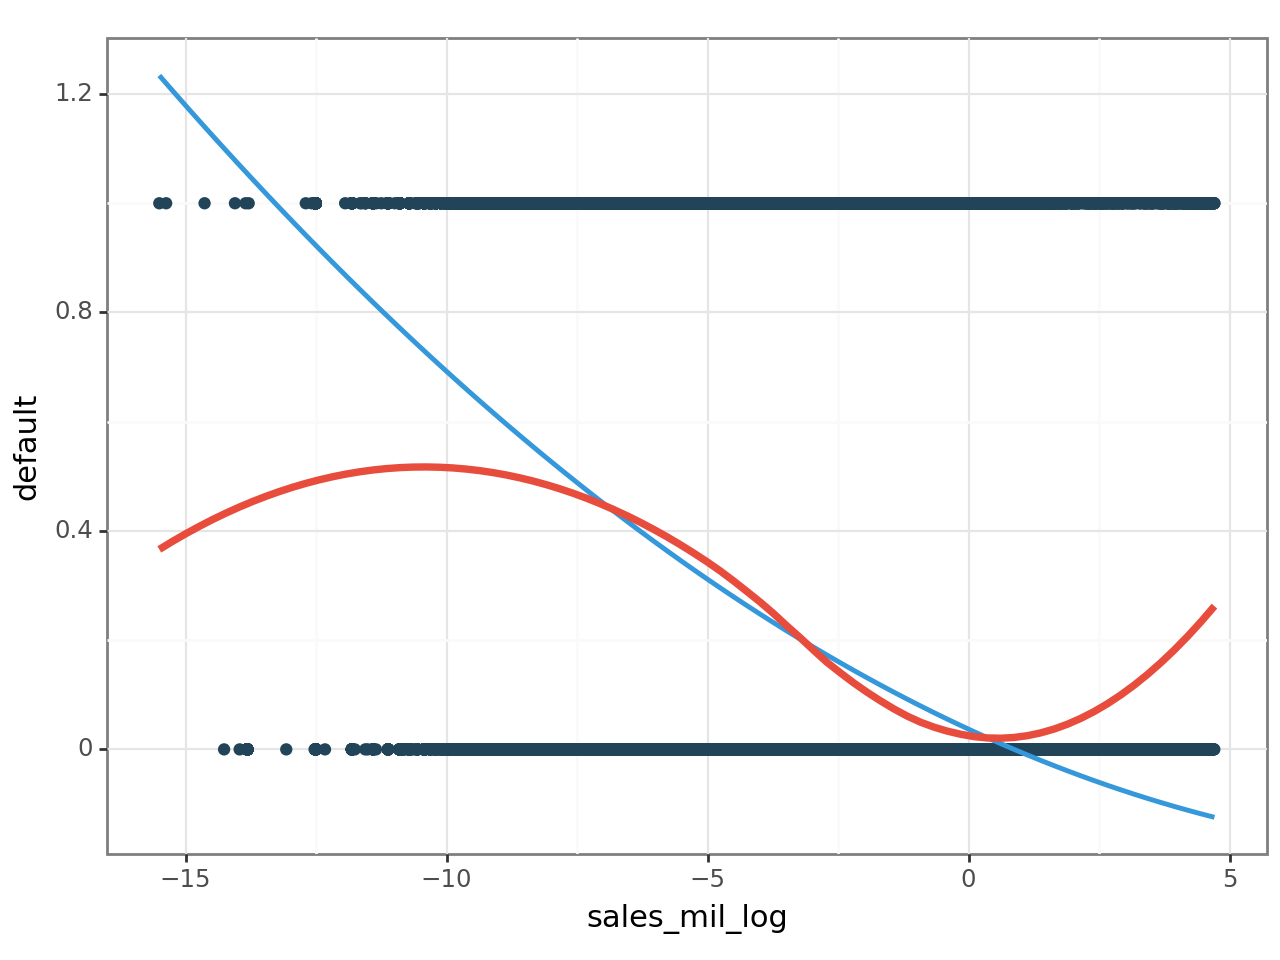

<Figure Size: (640 x 480)>

In [563]:
ggplot(data, aes(x="sales_mil_log", y="default")) + geom_point(
    color="#214459"
) + geom_smooth(
    method="lm", formula="y ~ x + I(x**2)", color="#3498db", se=False  # Assuming #3498db as a placeholder color
) + geom_smooth(
    method="loess", color="#e74c3c", se=False, size=1.5, span=0.9  # Assuming #e74c3c as a placeholder color
) + labs(
    x="sales_mil_log", y="default"
) + theme_bw()


In [564]:
# Performing linear regression: deault on logarithmic sales and squared logarithmic sales
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                 1.673e+04
Date:                Fri, 23 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:49:17   Log-Likelihood:            -1.1139e+05
No. Observations:              280392   AIC:                         2.228e+05
Df Residuals:                  280389   BIC:                         2.228e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0370      0.001  

### Change in sales

*Note:* Graphs are not in the book!

In [565]:
# lowess
data["d1_sales_mil_log"].describe()

count    556944.000000
mean          0.023417
std           0.870581
min         -13.815511
25%           0.000000
50%           0.000000
75%           0.000000
max          14.634809
Name: d1_sales_mil_log, dtype: float64

## 1.4 Hold Out Sample

In [566]:
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)


In [567]:
hold_out_sample = data[(data['ind2'] == 26) &
                     (data['sales'] >= 1000) &
                     (data['sales'] <= 10000000) &
                     (data['year'] == 2014)]
hold_out_sample

,year,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,...,current_ratio,quick_ratio,return_on_assets,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,default_f,sales_mil_log_sq
417864,2014,6.538183e+06,2014-01-01,2014-12-31,NaN,1018.518494,17022.222656,3040.740723,0.0,0.0,...,5.598051,5.598051,0.203344,52.5,0,0,0,0,default,9.011847
417890,2014,8.416055e+06,2014-01-01,2014-12-31,NaN,425.925934,105740.742188,6918.518555,0.0,0.0,...,15.283726,13.489829,-0.027249,54.0,0,0,0,0,default,9.939450
417942,2014,1.242838e+07,2014-01-01,2014-12-31,NaN,0.000000,0.000000,9277.777344,0.0,0.0,...,0.000000,0.000000,-inf,52.0,0,0,0,0,default,30.507003
417989,2014,1.777654e+07,2014-01-01,2014-12-31,NaN,48.148148,142296.296875,164237.031250,0.0,0.0,...,0.866408,0.109056,0.010282,43.5,0,0,0,0,no_default,2.402822
417994,2014,1.862676e+07,2014-01-01,2014-12-31,NaN,5755.555664,95185.187500,45766.667969,0.0,0.0,...,2.079793,1.755847,0.053106,36.0,0,0,0,1,default,3.176648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463875,2014,4.593723e+11,2014-01-01,2014-12-31,NaN,0.000000,40740.742188,559.259277,0.0,0.0,...,72.847682,72.847682,0.272000,39.0,0,0,0,1,default,15.972916
463965,2014,4.610112e+11,2014-01-01,2014-12-31,NaN,429.629639,58781.480469,2651.851807,0.0,0.0,...,22.166201,18.601955,0.028824,55.0,0,0,0,0,no_default,6.270351
464018,2014,4.620594e+11,2014-01-01,2014-12-31,NaN,1111.111084,68274.070312,16211.111328,0.0,0.0,...,4.211560,3.291981,0.007774,61.0,0,0,0,0,no_default,7.099340
464032,2014,4.623300e+11,2014-01-01,2014-12-31,NaN,0.000000,17192.591797,7325.925781,0.0,0.0,...,2.346815,2.346815,0.068191,52.5,0,0,0,0,default,12.497002


In [568]:
print("MISSING VALUES FROM HOLDOUT SAMPLE")
print("-"*35)
to_filter = hold_out_sample.isnull().sum()
to_filter[to_filter > 0]

MISSING VALUES FROM HOLDOUT SAMPLE
-----------------------------------


COGS                            948
amort                             2
finished_prod                   950
material_exp                      2
net_dom_sales                   948
net_exp_sales                   948
personnel_exp                     2
wages                           949
D                              1037
founded_year                     31
exit_year                      1014
ceo_count                        31
foreign                          31
female                           31
birth_year                      114
inoffice_days                    31
gender                           31
origin                           31
region_m                          2
exit_date                      1012
labor_avg                       312
age                              31
age2                             31
foreign_management               31
gender_m                         31
m_region_loc                      2
material_exp_pl                   2
personnel_exp_pl            

#### Hold Out Sample Summary Table

In [569]:
hold_out_summary = {
    'Number of Firms': [hold_out_sample.shape[0]],
    'Mean Sales': [hold_out_sample['sales'].mean()],
    'Min Sales': [hold_out_sample['sales'].min()],
    'Max Sales': [hold_out_sample['sales'].max()],
    'Defaulted Firms': [hold_out_sample['default'].sum()],
    'Stayed Alive Firms': [(hold_out_sample['default'] == 0).sum()]

}

hold_out_summary_df = pd.DataFrame(hold_out_summary)
hold_out_summary_df

,Number of Firms,Mean Sales,Min Sales,Max Sales,Defaulted Firms,Stayed Alive Firms
0,1037,490202.217927,1070.370361,9576485.0,55,982


## 1.5 Data Cleaning pt. 1

Missing values for a specific year (2014) and the entire dataset will be compared. 

In [570]:
# Filtering and creating a separate data set for 2014 data
data_2014 = data[(data['ind2'] == 26) &
                     (data['year'] == 2014)]
data_2014

,year,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,...,current_ratio,quick_ratio,return_on_assets,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,default_f,sales_mil_log_sq
417864,2014,6.538183e+06,2014-01-01,2014-12-31,NaN,1018.518494,17022.222656,3040.740723,0.0,0.0,...,5.598051,5.598051,0.203344,52.50000,0,0,0,0,default,9.011847
417890,2014,8.416055e+06,2014-01-01,2014-12-31,NaN,425.925934,105740.742188,6918.518555,0.0,0.0,...,15.283726,13.489829,-0.027249,54.00000,0,0,0,0,default,9.939450
417922,2014,1.089394e+07,2014-07-24,2014-12-31,NaN,0.000000,30614.814453,128055.546875,0.0,0.0,...,0.239074,0.144469,0.000000,46.00000,0,0,0,0,no_default,0.000000
417942,2014,1.242838e+07,2014-01-01,2014-12-31,NaN,0.000000,0.000000,9277.777344,0.0,0.0,...,0.000000,0.000000,-inf,52.00000,0,0,0,0,default,30.507003
417969,2014,1.571155e+07,2014-01-01,2014-12-31,NaN,0.000000,2477.777832,0.000000,0.0,0.0,...,inf,inf,0.000000,46.68887,0,0,1,0,no_default,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463940,2014,4.604901e+11,2014-01-01,2014-12-31,NaN,0.000000,33.333332,585.185181,0.0,0.0,...,0.056962,0.056962,-6.666667,59.00000,0,0,0,0,no_default,0.000000
463965,2014,4.610112e+11,2014-01-01,2014-12-31,NaN,429.629639,58781.480469,2651.851807,0.0,0.0,...,22.166201,18.601955,0.028824,55.00000,0,0,0,0,no_default,6.270351
464018,2014,4.620594e+11,2014-01-01,2014-12-31,NaN,1111.111084,68274.070312,16211.111328,0.0,0.0,...,4.211560,3.291981,0.007774,61.00000,0,0,0,0,no_default,7.099340
464032,2014,4.623300e+11,2014-01-01,2014-12-31,NaN,0.000000,17192.591797,7325.925781,0.0,0.0,...,2.346815,2.346815,0.068191,52.50000,0,0,0,0,default,12.497002


In [571]:
# Comparing the missing values from the entire data set and data from 2014
print("MISSING VALUES FROM ENTIRE DATASET")
print("-"*35)
to_filter = data.isnull().sum()
to_filter[to_filter > 0]

MISSING VALUES FROM ENTIRE DATASET
-----------------------------------


begin                269115
end                  269115
COGS                 538687
amort                277155
curr_assets          269246
                      ...  
debt_equity_ratio    270613
current_ratio        271011
quick_ratio          271070
return_on_assets     280772
sales_mil_log_sq     276552
Length: 112, dtype: int64

After reviewing the null values, `COGS`, `finished_production`, `net_dom_sale`, `net_exp_sales`, and `wages` will most likely need to be dropped. 

The null values will need to be viewed for one specific year to get an understanding of null values where the company only iterates once in the dataframe.
This way the null values can be better interpreted. 

In [572]:
data_2014.isnull().sum()
print("MISSING VALUES FROM 2014 DATASET")
print("-"*33)
to_filter = data_2014.isnull().sum()
to_filter[to_filter > 0]

MISSING VALUES FROM 2014 DATASET
---------------------------------


COGS                 1176
amort                   5
extra_exp               1
extra_inc               1
extra_profit_loss       1
                     ... 
debt_equity_ratio       7
current_ratio           9
quick_ratio            11
return_on_assets        8
sales_mil_log_sq        1
Length: 72, dtype: int64

Here, we can verify that `COGS`, `finished_prod`, `net_dom_sale`, `net_exp_sales`, and `wages` will need to be dropped from the analysis. 

`exit_year` and `exit date` can stay since not all companies are exiting, and we are trying to predict how many companies will exit.

The `D` column will also be dropped for it's high frequency of missing values

Also dropping `ind` column, as it does not serve any use in this specific project.

With `labor_avg` having such a high number of missing values, this column will also be dropped.

In [573]:
# Dropping the columns with too many missing values in the original data
data = data.drop(columns = ['COGS',
                            'finished_prod',
                            'net_dom_sales',
                            'net_exp_sales',
                            'wages',
                            'D',
                            'ind',
                            'labor_avg'])

In [574]:
to_filter = data.isnull().sum()
to_filter[to_filter > 0]

begin                269115
end                  269115
amort                277155
curr_assets          269246
curr_liab            269246
                      ...  
debt_equity_ratio    270613
current_ratio        271011
quick_ratio          271070
return_on_assets     280772
sales_mil_log_sq     276552
Length: 104, dtype: int64

In [575]:
# Dropping the columns with too many missing values from the 2014 data
data_2014 = data_2014.drop(columns = ['COGS',
                                      'finished_prod',
                                      'net_dom_sales',
                                      'net_exp_sales',
                                      'wages',
                                      'D',
                                      'ind',
                                      'labor_avg'])

In [576]:
to_filter_2014 = data_2014.isnull().sum()
to_filter_2014[to_filter_2014 > 0]

amort                 5
extra_exp             1
extra_inc             1
extra_profit_loss     1
inc_bef_tax           1
                     ..
debt_equity_ratio     7
current_ratio         9
quick_ratio          11
return_on_assets      8
sales_mil_log_sq      1
Length: 65, dtype: int64

In [577]:
# Creating a function to handle missing values

def data_dish_washer(data):
    # Step 1: Imputing with 0: Fill specific columns with 0 in case of numerical values
    zero_fill_cols = ['amort',
                      'curr_assets',
                      'personnel_exp', 
                      'material_exp',
                      'liq_assets',
                      'inventories',
                      'intang_assets', 
                      'fixed_assets',
                      'extra_profit_loss',
                      'extra_inc',
                      'extra_exp', 
                      'curr_liab',
                      'tang_assets']
    data[zero_fill_cols] = data[zero_fill_cols].fillna(0)


    # Step 2: Imputing with median: Fill missing values with median where it makes sense
    median_fill_cols = ['sales',
                        'profit_loss_year',
                        'inc_bef_tax', 
                        'share_eq',
                        'subscribed_cap']
    for col in median_fill_cols:
        data[col] = data[col].fillna(data[col].median())

    # Step 3: Change: Drop rows with missing values in specified categorical columns
    row_drops = ['nace_main',
                 'ind2',
                 'ceo_count', 
                 'foreign', 
                 'female',
                 'inoffice_days',
                 'gender',
                 'origin']
    data = data.dropna(subset=row_drops)

    # Step 4: Fill missing regions with 'NaN'
    data['region_m'] = data['region_m'].fillna('NaN')

    # Step 5: Convert Date variables to datetime types
    datetime_columns = ['begin',
                        'end',
                        'founded_date',
                        'exit_date']
    for col in datetime_columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

    # Step 6: Verify Numeric Columns
    numeric_columns = ['year',
                       'founded_year',
                       'exit_year',
                       'birth_year']
    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Transforming the Infinite values with NaNs in data
    data = data.replace([np.inf, -np.inf], np.nan)
    
    # filter the dataset to be 2013 or before, and between 1000 and 10000000
    data = data[(data['sales'] >= 1000) &
                (data['ind2'] == 26) &
                (data['sales'] <= 10000000) &
                (data['year'] <= 2013)]
    
    return data

data = data_dish_washer(data)
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,current_ratio,quick_ratio,return_on_assets,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,default_f,sales_mil_log_sq
156,2005,6.538183e+06,2005-01-01,2005-12-31,792.592590,6237.037109,348.148163,0.000000,0.000000,0.000000,...,17.914893,17.914893,-0.144123,46.68887,0,0,1,0,no_default,12.464763
182,2005,8.416055e+06,2005-01-01,2005-12-31,3155.555664,71070.367188,25514.814453,74.074074,0.000000,-74.074074,...,2.785455,2.632893,0.000000,45.00000,0,0,0,0,no_default,2.985813
234,2005,1.242838e+07,2005-01-01,2005-12-31,3137.037109,1740.740723,2192.592529,0.000000,0.000000,0.000000,...,0.793919,0.793919,0.137374,46.68887,0,0,1,0,no_default,12.291621
261,2005,1.571155e+07,2005-01-01,2005-12-31,1592.592651,4740.740723,4970.370605,0.000000,7407.407227,7407.407227,...,0.953800,0.822653,0.056311,46.68887,0,0,1,0,no_default,22.081296
264,2005,1.600518e+07,2005-01-01,2005-12-31,5659.259277,71714.812500,40607.406250,0.000000,0.000000,0.000000,...,1.766053,0.771616,-0.049577,30.00000,0,0,0,1,no_default,2.241016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417463,2013,4.593723e+11,2013-01-01,2013-12-31,0.000000,29992.591797,888.888916,0.000000,0.000000,0.000000,...,33.741665,33.741665,0.440109,38.00000,0,0,0,1,no_default,16.543565
417553,2013,4.610112e+11,2013-01-01,2013-12-31,744.444458,57648.148438,3518.518555,0.000000,0.000000,0.000000,...,16.384210,14.350526,-0.076422,54.00000,0,0,0,0,no_default,6.922360
417606,2013,4.620594e+11,2013-01-01,2013-12-31,670.370361,65170.371094,17066.666016,0.000000,0.000000,0.000000,...,3.818577,2.706597,0.000837,60.00000,0,0,0,0,no_default,8.743910
417620,2013,4.623300e+11,2013-01-01,2013-12-31,0.000000,11551.851562,5174.074219,0.000000,0.000000,0.000000,...,2.232641,2.232641,0.152211,51.50000,0,0,0,0,no_default,12.411447


In [578]:
to_filter = data.isnull().sum()
to_filter[to_filter > 0]

exit_year            6862
birth_year           1912
exit_date            6862
ln_sales              168
sales_mil             168
                     ... 
debt_equity_ratio      24
current_ratio         255
quick_ratio           255
return_on_assets       37
sales_mil_log_sq      168
Length: 65, dtype: int64

In [579]:
data.isnull().sum().sum()

22513

In [580]:
data.columns

Index(['year', 'comp_id', 'begin', 'end', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss',
       ...
       'current_ratio', 'quick_ratio', 'return_on_assets', 'ceo_age',
       'flag_low_ceo_age', 'flag_high_ceo_age', 'flag_miss_ceo_age',
       'ceo_young', 'default_f', 'sales_mil_log_sq'],
      dtype='object', length=117)

In [581]:
data.dtypes

year                          int64
comp_id                     float64
begin                datetime64[ns]
end                  datetime64[ns]
amort                       float64
                          ...      
flag_high_ceo_age             int32
flag_miss_ceo_age             int32
ceo_young                     int32
default_f                  category
sales_mil_log_sq            float64
Length: 117, dtype: object

In [582]:
# data['sales_log']

In [583]:
data['sales'].describe()

count    7.872000e+03
mean     4.008075e+05
std      1.060820e+06
min      1.000000e+03
25%      2.151019e+04
50%      6.500741e+04
75%      2.358306e+05
max      9.884141e+06
Name: sales, dtype: float64

In [584]:
# Custom function to format the describe output
def format_describe(describe_dict):

    formatted_describe = {k: '{:,.2f}'.format(v) for k, v in describe_dict.items()}
    return formatted_describe

# Format the mock describe data
formatted_sales_describe = format_describe(data['sales'].describe())
formatted_sales_describe

{'count': '7,872.00',
 'mean': '400,807.55',
 'std': '1,060,819.99',
 'min': '1,000.00',
 '25%': '21,510.19',
 '50%': '65,007.41',
 '75%': '235,830.56',
 'max': '9,884,141.00'}

<Axes: >

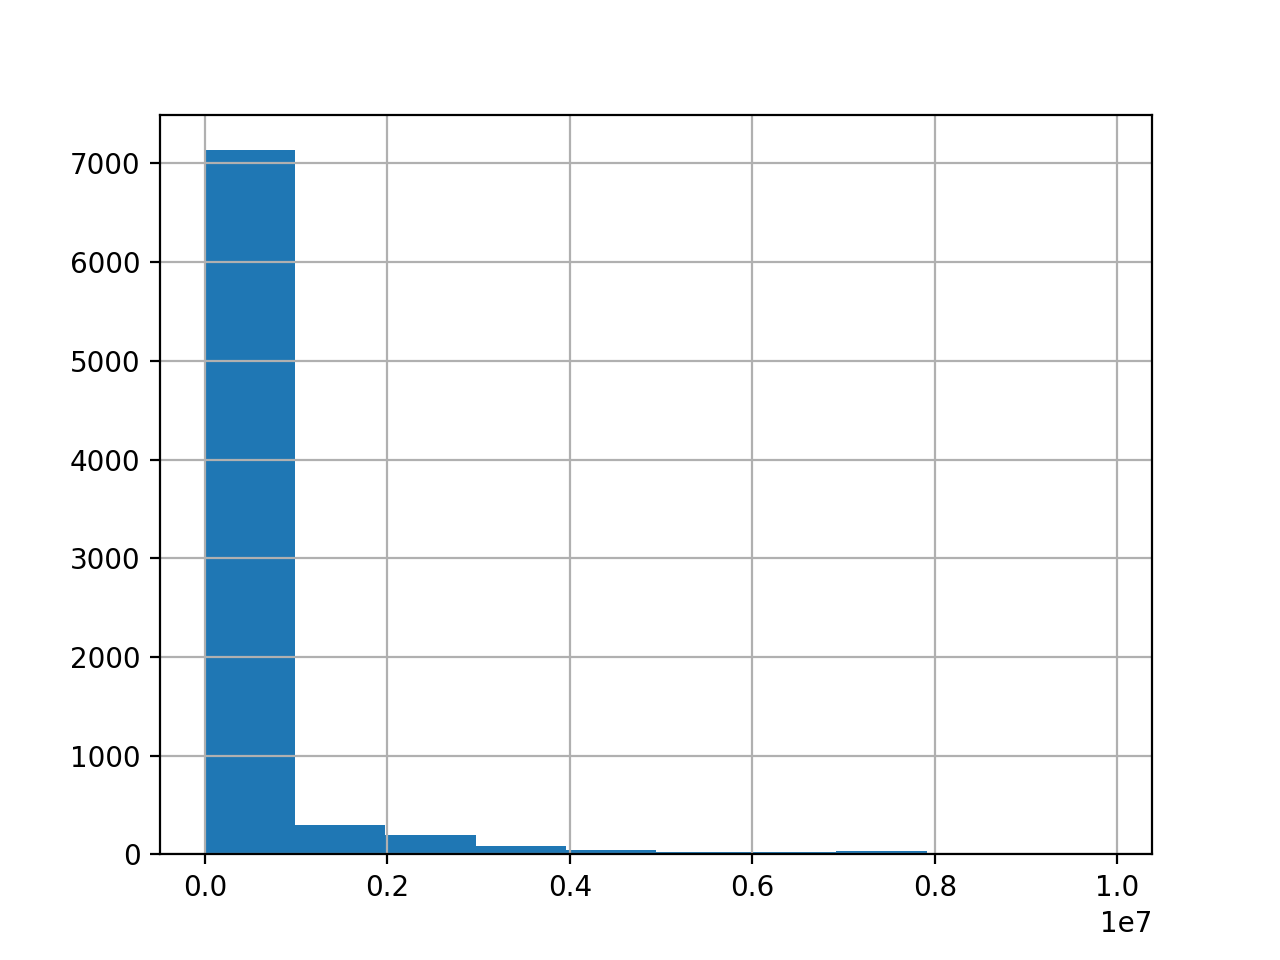

In [585]:
data.sales.hist()

With such a large range, the sales are getting automatically transformed in an unreadable way for visualizations.

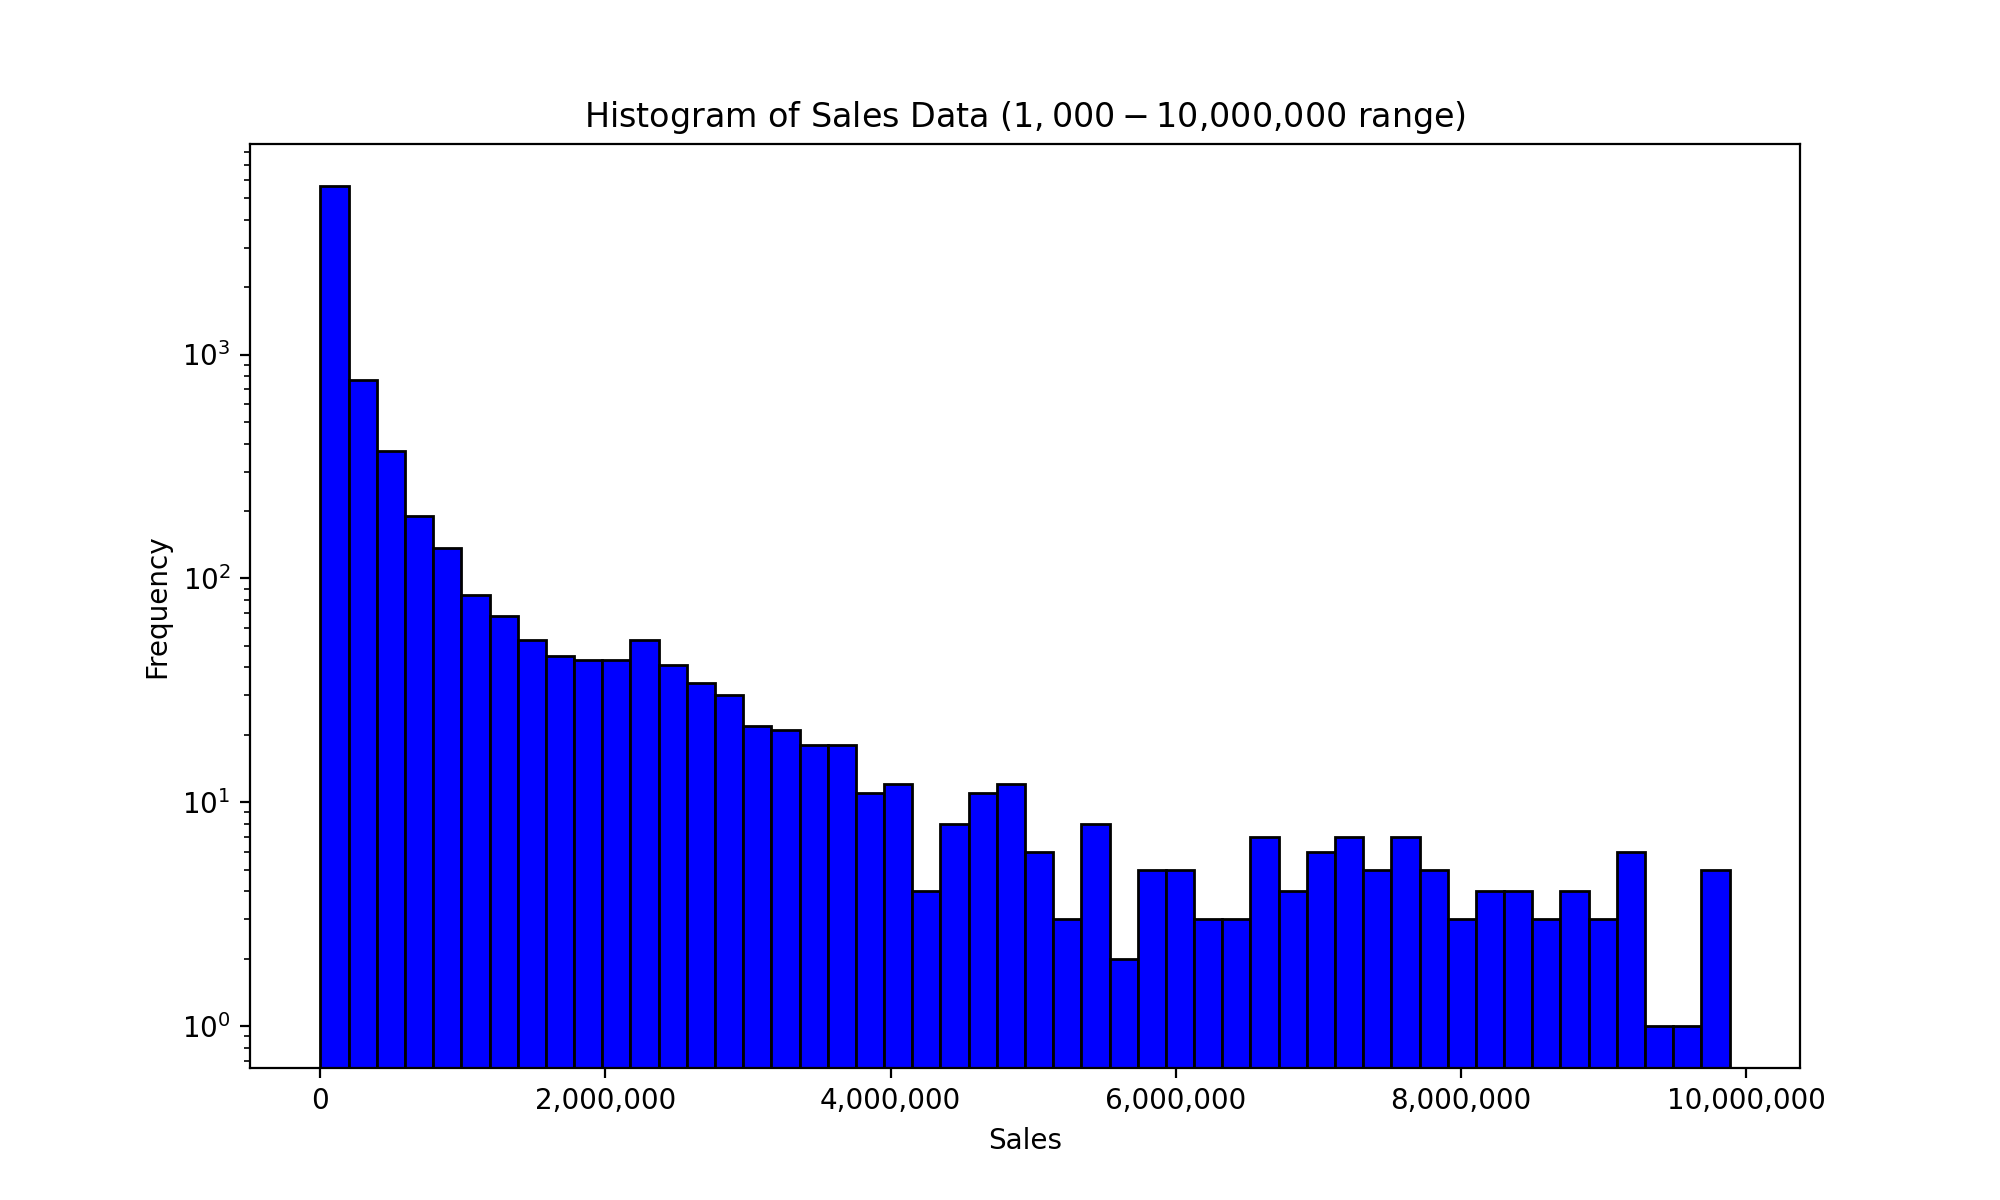

In [586]:
# Filter the data to include only sales within the specified range
filtered_sales = data['sales'][(data['sales'] >= 1000) & (data['sales'] <= 10000000)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_sales, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Sales Data ($1,000 - $10,000,000 range)')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale for better visualization

# Set x-axis to show actual values with custom formatting
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()


Fitting the sales in a range gives it a much more readable view. There is a huge skew of data, so log trasformation is appropriate.

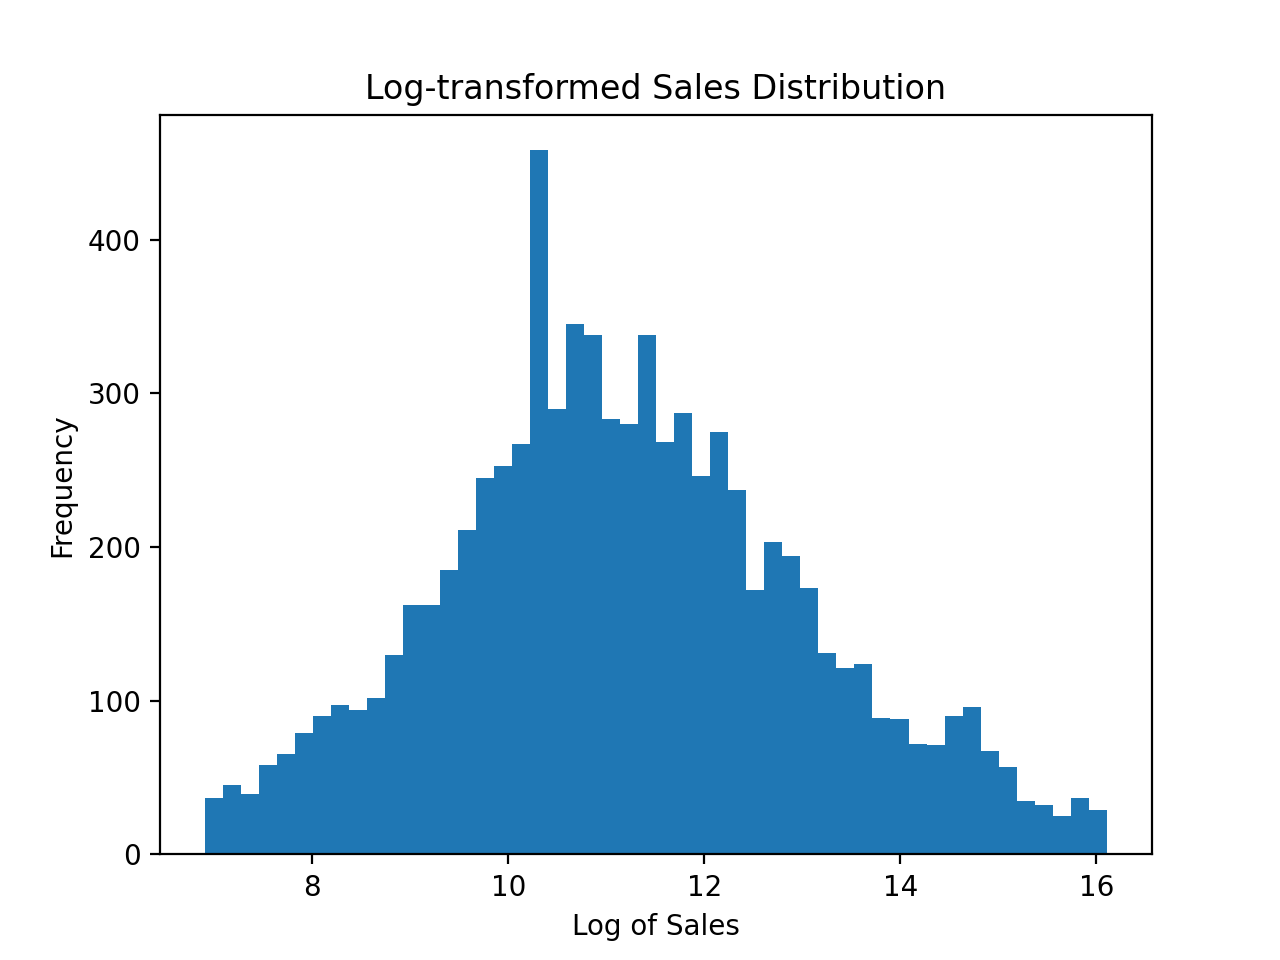

In [587]:
# Apply log transformation to sales data
data['sales_log'] = np.log1p(filtered_sales)
plt.hist(data['sales_log'], bins=50)
plt.xlabel('Log of Sales')
plt.ylabel('Frequency')
plt.title('Log-transformed Sales Distribution')
plt.show()


## 1.6 Model Building

### 1.6.1 Define Variable Sets

#### Main Firm Variables

In [588]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

#### Further financial variables

In [589]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

#### Financial Ratios

In [590]:
financial_ratios = [
    "gross_profit_margin",
    "net_profit_margin",
    "return_on_equity",
    "debt_equity_ratio",
    "current_ratio",
    "quick_ratio",
    "return_on_assets"
]

#### Flag Variables

In [591]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

#### Growth Variables

d1 = [
    "d1_sales_mil_log",
    "d1_sales_mil_log_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

#### Human capital related variables

In [592]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "foreign_management",
]

#### Firms history related variables

In [593]:
firm = ["age",
        "age2",
        "new",
        "C(ind2_cat)",
        "C(m_region_loc)",
        "C(urban_m)"]

#### Interactions for logit, LASSO

interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)"
]

In [594]:

interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]



### 1.6.2 Model Setups

#### 1. Simple Logit Models

In [595]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management"
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + financial_ratios
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + financial_ratios
    + interactions2
)

#### 2. Logit+LASSO

In [596]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + hr
    + firm
    + qualityvars
    + financial_ratios
    + interactions2
)

#### 3. CART and RF (no interactions, no modified features)

In [597]:
rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars + financial_ratios

# ***Predictive Models***

## Linear Probability Models

In [598]:
ols_modelx2 = smf.ols("default~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     23.67
Date:                Fri, 23 Feb 2024   Prob (F-statistic):           1.80e-44
Time:                        16:50:37   Log-Likelihood:                 541.89
No. Observations:                7703   AIC:                            -1062.
Df Residuals:                    7692   BIC:                            -985.3
Df Model:                          10                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0684      0.014      4.938      0.000       0.041       0.096
sales_mil_log               0.0061      0.003      1.904      0.057      -0.000       0.012
sales_mil_log_sq            0.0044      0.001      5.960      0.000       0.003       0.006
profit_loss_year_pl        -0.0217      0.016     -1.318      0.187      -0.054       0.011
fixed_assets_bs            -0.0399      0.011     -3.640      0.000      -0.061      -0.018
share_eq_bs                -0.0213      0.011     -1.891      0.059      -0.043       0.001
curr_liab_bs               -0.0124      0.015     -0.855      0.393      -0.041       0.016
curr_liab_bs_flag_high      0.0720      0.017      4.215      0.000       0.039       0.106
curr_liab_bs_flag_error    -0.0343      0.014     -2.422      0.015      -0.062      -0.007
age                        -0.0023      0.000     -5.124      0.000      -0.003      -0.001
foreign_management          0.0223      0.009      2.576      0.010       0.005       0.039
==============================================================================
Omnibus:                     5478.941   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57717.300
Skew:                           3.513   Prob(JB):                         0.00
Kurtosis:                      14.422   Cond. No.                         623.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [599]:
logit_modelx2 = smf.logit("default~" + "+".join(M2), data).fit()

         Current function value: 0.196688
         Iterations: 35


In [600]:
logit_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7703
Model:                          Logit   Df Residuals:                     7692
Method:                           MLE   Df Model:                           10
Date:                Fri, 23 Feb 2024   Pseudo R-squ.:                  0.1018
Time:                        16:50:38   Log-Likelihood:                -1515.1
converged:                      False   LL-Null:                       -1686.7
Covariance Type:            nonrobust   LLR p-value:                 1.065e-67
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.0234      0.237    -12.731      0.000      -3.489      -2.558
sales_mil_log              -0.0699      0.076     -0.917      0.359      -0.219       0.079
sales_mil_log_sq            0.0406      0.011      3.585      0.000       0.018       0.063
profit_loss_year_pl        -0.1685      0.149     -1.133      0.257      -0.460       0.123
fixed_assets_bs            -0.7317      0.202     -3.624      0.000      -1.127      -0.336
share_eq_bs                -0.2475      0.149     -1.656      0.098      -0.540       0.045
curr_liab_bs               -0.0157      0.246     -0.064      0.949      -0.498       0.466
curr_liab_bs_flag_high      0.7229      0.211      3.430      0.001       0.310       1.136
curr_liab_bs_flag_error   -14.1414   2440.707     -0.006      0.995   -4797.839    4769.557
age                        -0.0474      0.009     -5.503      0.000      -0.064      -0.031
foreign_management          0.5186      0.146      3.558      0.000       0.233       0.804
===========================================================================================
"""

In [601]:
logit_modelx2.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                default
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sales_mil_log              -0.0035      0.004     -0.916      0.360      -0.011       0.004
sales_mil_log_sq            0.0020      0.001      3.581      0.000       0.001       0.003
profit_loss_year_pl        -0.0085      0.007     -1.133      0.257      -0.023       0.006
fixed_assets_bs            -0.0369      0.010     -3.606      0.000      -0.057      -0.017
share_eq_bs                -0.0125      0.008     -1.655      0.098      -0.027       0.002
curr_liab_bs               -0.0008      0.012     -0.064      0.949      -0.025       0.023
curr_liab_bs_flag_high      0.0364      0.011      3.418      0.001       0.016       0.057
curr_liab_bs_flag_error    -0.7124    122.956     -0.006      0.995    -241.703     240.278
age                        -0.0024      0.000     -5.431      0.000      -0.003      -0.002
foreign_management          0.0261      0.007      3.537      0.000       0.012       0.041
===========================================================================================
"""

## 1. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [602]:
data_train = data.copy()

In [603]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) cross validate logit models

Set up X-vars

In [604]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [605]:
C_value_logit = [1e20]

In [606]:
from sklearn.impute import SimpleImputer
import time

logit_models = dict()
CV_RMSE_folds = dict()

# Start the overall timer
overall_start_time = time.time()

for i, model_vars in enumerate(logit_model_vars):
    # Start the timer for the current iteration
    start_time = time.time()

    # Define the model equation using patsy's dmatrices
    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)
    
    # Flatten y_train to 1D array if necessary for scikit-learn
    y_train = y_train.ravel()

    # Check for infinite values in X_train and replace them with NaN
    X_train = pd.DataFrame(X_train, columns=X_train.design_info.column_names)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)

    # Impute the NaN values in X_train
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)

    # Initialize LogisticRegressionCV
    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    # Fit the model with imputed data
    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train_imputed, y_train)

    # Calculate RMSE on test for each fold using the stored scores
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

    # End the timer for the current iteration and print the update
    end_time = time.time()
    print(f"Completed model {i + 1}/{len(logit_model_vars)}. Time taken: {end_time - start_time:.2f} seconds.")

# Print the total time taken
overall_end_time = time.time()
print(f"Total time taken: {overall_end_time - overall_start_time:.2f} seconds.")


Completed model 1/5. Time taken: 0.29 seconds.
Completed model 2/5. Time taken: 0.54 seconds.
Completed model 3/5. Time taken: 2.52 seconds.
Completed model 4/5. Time taken: 4.83 seconds.
Completed model 5/5. Time taken: 5.25 seconds.
Total time taken: 13.43 seconds.


In [607]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.241527,0.239000,0.243695,0.472008,0.472008
1,0.212407,0.212866,0.228338,0.215245,0.214657
2,0.226066,0.222450,0.245666,0.212489,0.211504
3,0.235832,0.234188,0.477578,0.236257,0.236824
4,0.225048,0.222679,0.245863,0.230373,0.231621


### b) Logit + LASSO

In [608]:
model_equation = "default~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

In [609]:
# Assume X_train is created from patsy.dmatrices
y_train, X_train = patsy.dmatrices(model_equation, data_train)

# Convert y_train to a DataFrame for easy handling
y_train_df = pd.DataFrame(y_train, columns=['default'])

# Extract column names right after creating X_train with patsy.dmatrices
column_names = X_train.design_info.column_names

# Then, convert X_train to a pandas DataFrame if not already done
X_train_df = pd.DataFrame(X_train, columns=column_names)

# Replace infinite values with NaN
X_train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop NaN values from X_train_df
X_train_df.dropna(inplace=True)

# Find the index of rows kept after dropping NaNs
kept_indices = X_train_df.index

# Filter y_train_df to keep only the indices that remain in X_train_df
y_train_df = y_train_df.loc[kept_indices]

normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train_df),
    columns=column_names  # Use the extracted column names
)


In [610]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

In [611]:
y_train_prepared = y_train_df['default'].values.ravel()

logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train_prepared)


In [612]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.001670,0.248368
1,0.046416,0.003599,0.232037
2,0.021544,0.007754,0.224179
3,0.010000,0.016705,0.220836
4,0.004642,0.035989,0.220256
5,0.002154,0.077536,0.221163
6,0.001000,0.167045,0.221011
7,0.000464,0.359888,0.221222
8,0.000215,0.775356,0.221564
9,0.000100,1.670453,0.221840


In [613]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

In [614]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

In [615]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO
0,0.241527,0.239000,0.243695,0.472008,0.472008,0.221823
1,0.212407,0.212866,0.228338,0.215245,0.214657,0.213409
2,0.226066,0.222450,0.245666,0.212489,0.211504,0.206258
3,0.235832,0.234188,0.477578,0.236257,0.236824,0.230332
4,0.225048,0.222679,0.245863,0.230373,0.231621,0.228515


## 2.  AUC, Calibration Curve, Confusion Matrix, ROC

0. Calculate AUC for folds


First, for logits

In [616]:
CV_AUC_folds = dict()

# Ensure np and pd are already imported
for i, model_vars in enumerate(logit_model_vars):
    # Generate the model equation
    model_equation = "default~" + "+".join(model_vars)
    
    # Use patsy.dmatrices to generate X and y matrices
    y_train, X_train = patsy.dmatrices(model_equation, data_train)
    
    # Convert X_train to a pandas DataFrame for easier manipulation
    X_train_df = pd.DataFrame(X_train, columns=X_train.design_info.column_names)
    
    # Now you can safely replace infinities with NaN
    X_train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train_df)

    # Normalize the variables using StandardScaler
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train_imputed)

    # Flatten y_train to fit the model
    y_train = y_train.ravel()

    # Fit the model
    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )
    
    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train_normalized, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()


For Lasso

In [617]:
print("X_train shape:", normalized_logitvars.shape)
print("y_train shape:", y_train.shape)

X_train shape: (7483, 91)
y_train shape: (7483,)


In [618]:
# Example of dropping rows with NaN values from both X and y (use only if necessary and appropriate)
# First, ensure X_train_df is aligned with y_train
X_train_df['target'] = y_train.ravel()  # Temporarily append y_train to X for aligned row dropping
cleaned_df = X_train_df.dropna()  # Drop rows with NaN values
y_train_cleaned = cleaned_df['target'].values  # Extract the cleaned y_train
X_train_cleaned = cleaned_df.drop(columns=['target'])  # Drop the temporary y_train column

# Proceed with normalization and model fitting using the cleaned datasets


In [619]:
# Convert X_train_df back to the format needed for model fitting after cleaning
X_train_cleaned = cleaned_df.drop(columns=['target'])  # Assuming cleaned_df is your cleaned DataFrame
y_train_cleaned = cleaned_df['target'].values  # This is correct

# Now, you should normalize and fit the model on X_train_cleaned and y_train_cleaned
# Ensure normalization (if not already done) and model fitting uses these cleaned variables

# Re-check the shapes after the cleaning process
print("X_train_cleaned shape:", X_train_cleaned.shape)
print("y_train_cleaned shape:", y_train_cleaned.shape)

X_train_cleaned shape: (7483, 91)
y_train_cleaned shape: (7483,)


In [620]:
# Normalize X_train_cleaned
scaler = StandardScaler()
X_train_cleaned_normalized = scaler.fit_transform(X_train_cleaned)

# Initialize and fit the logistic regression model with L1 penalty (LASSO) on the cleaned and normalized data
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)

# Fit the model
logLasso_auc_fitted = logLasso_auc.fit(X_train_cleaned_normalized, y_train_cleaned)

if 1 in logLasso_auc_fitted.scores_:
    class_label = 1
else:
    class_label = list(logLasso_auc_fitted.scores_.keys())[0]  # Fallback to the first key

# Assuming cv_summary_lasso is a summary statistic from cross-validation, adjust as necessary
# For simplicity, this example uses the mean score across folds for the class of interest
CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[class_label][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]


In [621]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [622]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

16

In [623]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

16

In [624]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,17,0.228176,0.694846
M2,11,0.226237,0.748864
M3,38,0.288228,0.725501
M4,87,0.273275,0.749375
M5,91,0.273323,0.748499
LASSO,16,0.220067,0.773700


### Take best model and estimate RMSE on holdout  

We will go with lasso since it is a simpler model with the lowest RMSE


ther were a ton of errors coming up about legnths and infinte values. the following three code blocks "correct" those errors. but, the real issue is probably something deeper in the code that could be fixed and resolve the issue. 

In [642]:
y_train = data['default']
X_train = data.drop('default', axis=1)  # This removes the target column from the features

model_equation = "default ~ " + " + ".join(logit_lasso_vars)  # features_vars should be the list of your feature variable names
y_train, X_train = patsy.dmatrices(model_equation, data)



In [643]:
# Initialize the imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit the imputer on X_train
# If X_train is a patsy DesignMatrix, convert it to DataFrame first
X_train_df = pd.DataFrame(X_train, columns=X_train.design_info.column_names)
imputer.fit(X_train_df)


SimpleImputer()

In [645]:
# Initialize the scaler
scaler = StandardScaler()

# transform X_train using the fitted imputer before fitting the scaler
X_train_imputed = imputer.transform(X_train_df)

# Fit the scaler on the imputed data
scaler.fit(X_train_imputed)


StandardScaler()

In [647]:
best_logit = logit_models["LASSO"]
_, X_holdout = patsy.dmatrices("default~" + "+".join(logit_lasso_vars), hold_out_sample)
X_holdout_df = pd.DataFrame(X_holdout, columns=X_holdout.design_info.column_names)
X_holdout_df.replace([np.inf, -np.inf], np.nan, inplace=True)
X_holdout_imputed = imputer.transform(X_holdout_df)
X_holdout_scaled = scaler.transform(X_holdout_imputed)
proba_predictions = best_logit.predict_proba(X_holdout_scaled)[:, 1]

# Adjust hold_out_sample to match the length of proba_predictions if necessary
hold_out_sample_adjusted = hold_out_sample.iloc[:len(proba_predictions)].copy()
hold_out_sample_adjusted["best_logit_pred_proba"] = proba_predictions
rmse_value = np.sqrt(mean_squared_error(hold_out_sample_adjusted["default"], hold_out_sample_adjusted["best_logit_pred_proba"]))
print("RMSE:", round(rmse_value, 3))


RMSE: 0.221


### a) Calibration curve

how well do estimated vs actual event probabilities relate to each other?


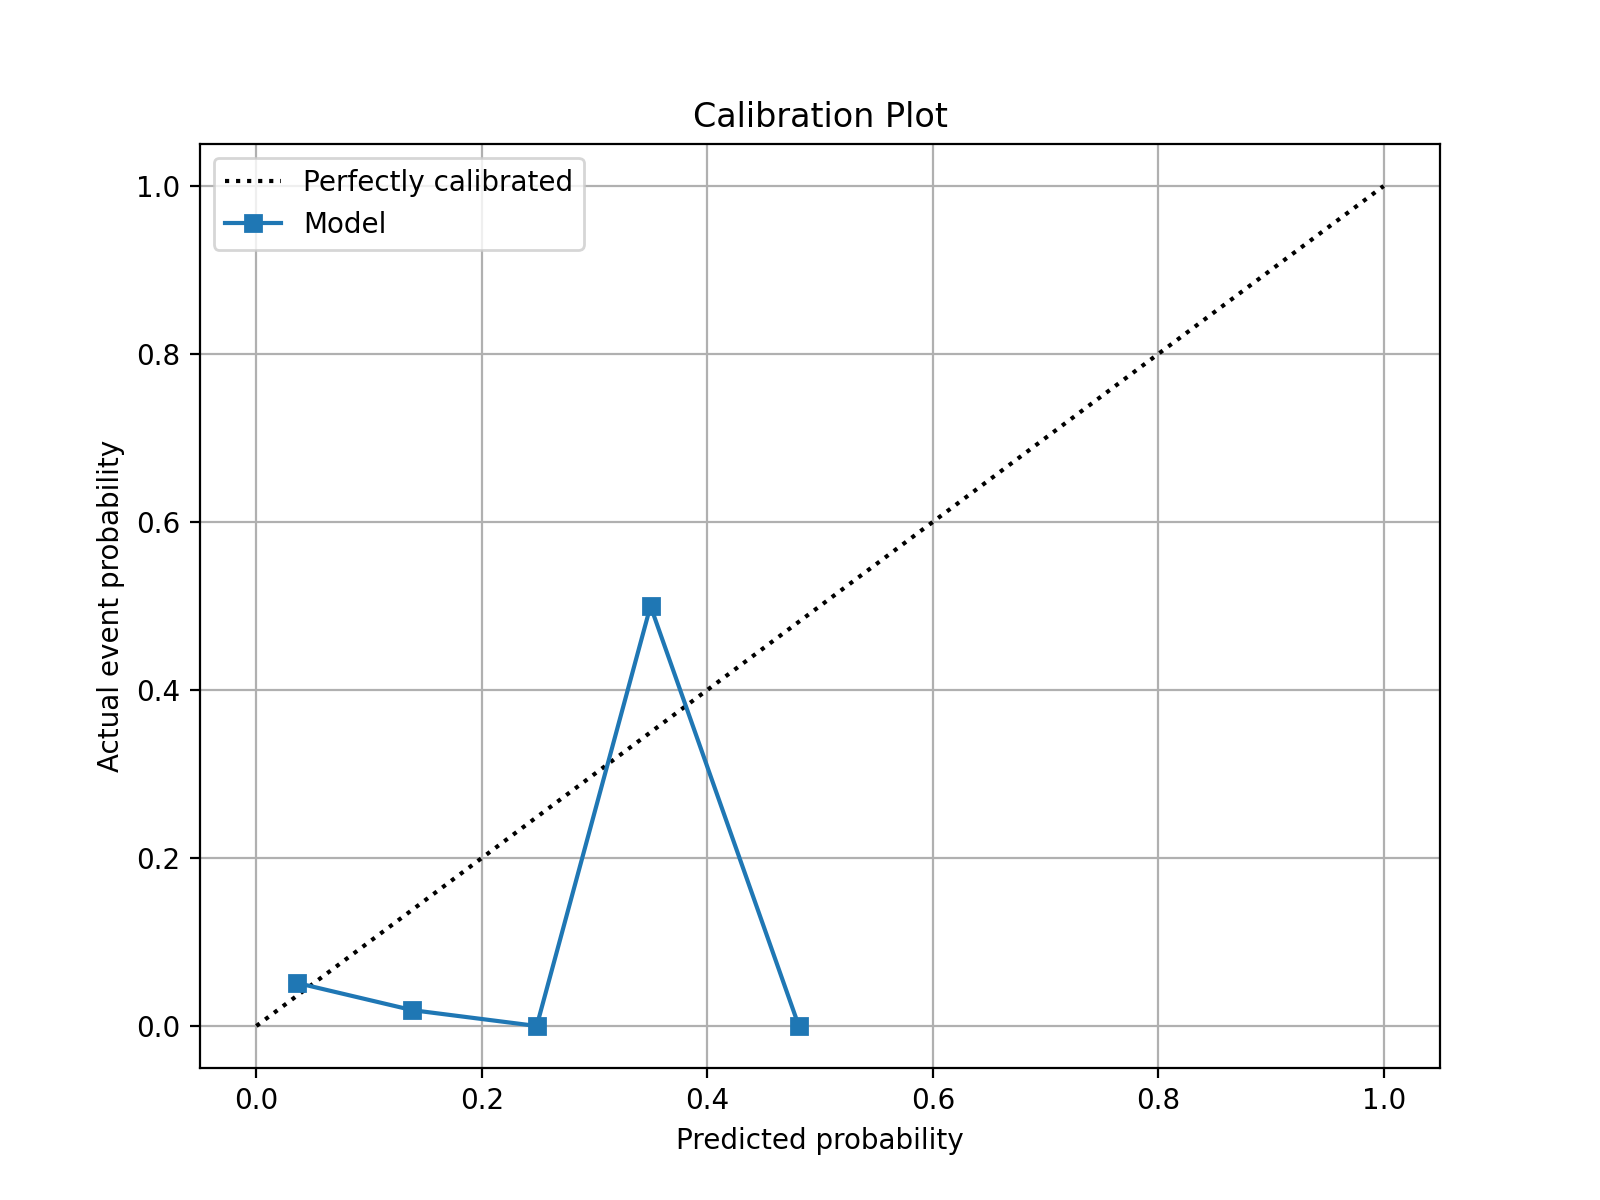

In [668]:
create_calibration_plot(
    data=hold_out_sample_adjusted,
    file_name="figure-1-logit-lasso-calibration",
    prob_var="best_logit_pred_proba",
    actual_var="default",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None
)

something is wrong with the calibration, we will need to go back through everything and try to figure it out